# 12 Clipping

In this lesson we will learn how to to clip different geometries.

## About the data

We will use three datasets in this lesson. 

The first dataset is a [TIGER shapefile of the US states from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). Follow these steps to download shapefile with the United States' states:

You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

The second dataset we'll use is [Natural Earth's simple medium scale populated places dataset](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). We can obtain this dataset by downloading the shapefile (choose the one that says "simple (less columns)").

The third dataset we'll use is [Natural Earth's road dataset](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/roads/). 
We can obtain this dataset by downloading the shapefile 

We will combine these datasets to create the following map of infrastructure in Alaska:

## Import data

Let's start by loading our libraries and then importing the datasets we will use.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import box  # To create polygon bounding box

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

pd.set_option("display.max.columns", None)

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import and simplify states polygons
states = gpd.read_file(os.path.join(data_folder_fp, 
                                    'tl_2022_us_state', 
                                    'tl_2022_us_state.shp'))

# Import Natural Earth populated places points
places = gpd.read_file(os.path.join(data_folder_fp,
                                    'ne_50m_populated_places',
                                    'ne_50m_populated_places.shp')
                                    )

# Import ferry routes lines
roads = gpd.read_file(os.path.join(data_folder_fp,
                                   'ne_10m_roads',
                                   'ne_10m_roads.shp')
                                   )

## Check-in
Use a for loop to iterate over the three geo-dataframes we imported and change their column names to lower caps.

In [17]:
# For loop to clean column names and make lowercase
data_list = [states, places, roads]

for data in data_list:
    data.columns = (data.columns # Select columns
                  .str.lower() # Set strings to lowercase
                  .str.strip()) # Remove leading and tailing spaces

In [18]:
states.columns

Index(['region', 'division', 'statefp', 'statens', 'geoid', 'stusps', 'name',
       'lsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat', 'intptlon',
       'geometry'],
      dtype='object')

In [19]:
states.head()

,region,division,statefp,statens,geoid,stusps,name,lsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266456923,489045863,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138962819934,45971472526,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778515726,6216539665,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206244837557,18937184315,+46.3159573,-094.1996043,"POLYGON ((-95.31989 48.99892, -95.31747 48.998..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151771744,6979295311,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243..."


<Axes: >

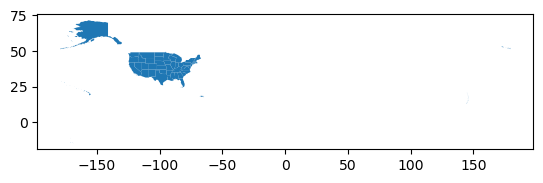

In [14]:
# Select Alaska
alaska = states[states.name == "Alaska"]
states.plot()

Notice the multipolygon is plotted under the NAD83/EPSG:4269 CTS. This unnaturally elongates the map.

So let's reproject!

In [15]:
# Project Alaska crs
alaska = alaska.to_crs('epsg:3338')

# Inspect new crs
print('Is this CRS projected?', alaska.crs.is_projected)
alaska.crs

Is this CRS projected? True


<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meter)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

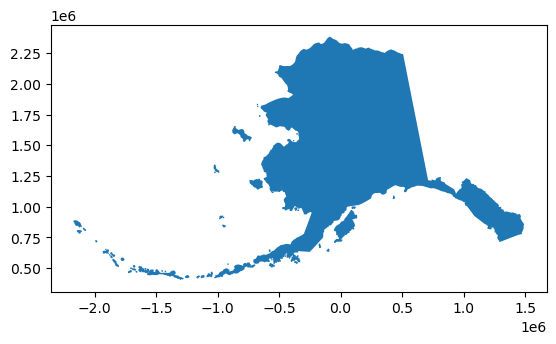

In [16]:
alaska.plot()

## Prepare populated places points

In [20]:
places.head(3)

,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,nameascii,adm0cap,capin,worldcity,megacity,sov0name,sov_a3,adm0name,adm0_a3,adm1name,iso_a2,note,latitude,longitude,pop_max,pop_min,pop_other,rank_max,rank_min,meganame,ls_name,max_pop10,max_pop20,max_pop50,max_pop300,max_pop310,max_natsca,min_areakm,max_areakm,min_areami,max_areami,min_perkm,max_perkm,min_permi,max_permi,min_bbxmin,max_bbxmin,min_bbxmax,max_bbxmax,min_bbymin,max_bbymin,min_bbymax,max_bbymax,mean_bbxc,mean_bbyc,timezone,un_fid,pop1950,pop1955,pop1960,pop1965,pop1970,pop1975,pop1980,pop1985,pop1990,pop1995,pop2000,pop2005,pop2010,pop2015,pop2020,pop2025,pop2050,min_zoom,wikidataid,wof_id,capalt,name_en,name_de,name_es,name_fr,name_pt,name_ru,name_zh,label,name_ar,name_bn,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_sv,name_tr,name_vi,ne_id,name_fa,name_he,name_uk,name_ur,name_zht,geonamesid,fclass_iso,fclass_us,fclass_fr,fclass_ru,fclass_es,fclass_cn,fclass_tw,fclass_in,fclass_np,fclass_pk,fclass_de,fclass_gb,fclass_br,fclass_il,fclass_ps,fclass_sa,fclass_eg,fclass_ma,fclass_pt,fclass_ar,fclass_jp,fclass_ko,fclass_vn,fclass_tr,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry
0,10,1,5,Admin-1 region capital,Bombo,None,None,Bombo,0,None,0,0,Uganda,UGA,Uganda,UGA,Bamunanika,UG,None,0.583299,32.533300,75000,21000,0.0,8,7,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q4940747,1141906025,0,Bombo,Bombo,Bombo,Bombo,Bombo,Бомбо,邦博,None,بومبو,বোম্বো,Μπόμπο,बॉम्बो,Bombo,Bombo,Bombo,ボンボ,봄보,Bombo,Bombo,Bombo,Bombo,Bombo,1159113923,بمبو,בומבו,Бомбо,بومبو,邦博,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (32.53330 0.58330)
1,10,1,5,Admin-1 region capital,Fort Portal,None,None,Fort Portal,0,None,0,0,Uganda,UGA,Uganda,UGA,Kabarole,UG,None,0.671004,30.275002,42670,42670,0.0,7,7,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa/Kampala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q500107,421174009,0,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Форт-Портал,波特爾堡,None,فورت بورتال,ফোর্ট পোর্টাল,Φορτ Πορτάλ,फोर्ट पोर्टल,Fort Portal,Fort Portal,Fort Portal,フォート・ポータル,포트포털,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Fort Portal,1159113959,فورت پورتال,פורט פורטל,Форт-Портал,فورٹ پورٹل,波特爾堡,233476.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (30.27500 0.67100)
2,10,1,3,Admin-1 region capital,Potenza,None,None,Potenza,0,None,0,0,Italy,ITA,Italy,ITA,Basilicata,IT,None,40.642002,15.798997,69060,69060,0.0,8,8,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Europe/Rome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q3543,101752567,0,Potenza,Potenza,Potenza,Potenza,Potenza,Потенца,波坦察,None,بوتنسا,পোটেঞ্জা,Ποτέντσα,पोटेंजा,Potenza,Potenza,Potenza,ポテンツァ,포텐차,Potenza,Potenza,Potenza,Potenza,Potenza,1159117259,پوتنزا,פוטנצה,Потенца,پوتینتسا,波坦察,3170027.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (15.79900 40.64200)


This dataset is WGS84 / EPSG: 4326 CRS
This is the most widely used CRS for global data

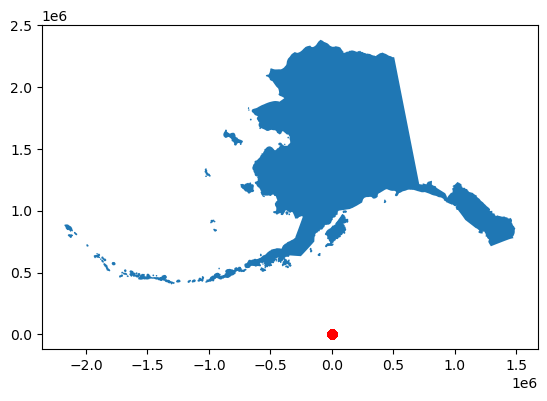

In [21]:
fig, ax = plt.subplots()

alaska.plot(ax=ax)
places.plot(ax=ax, color='red')

plt.show()

In [23]:
if alaska.crs == places.crs:
    print('CRSs match')
else: 
    places = places.to_crs(alaska.crs)
    assert places.crs == alaska.crs
    print('Original data CRS did not match, Reprojected to match CRS')

Original data CRS did not match, Reprojected to match CRS


<Axes: >

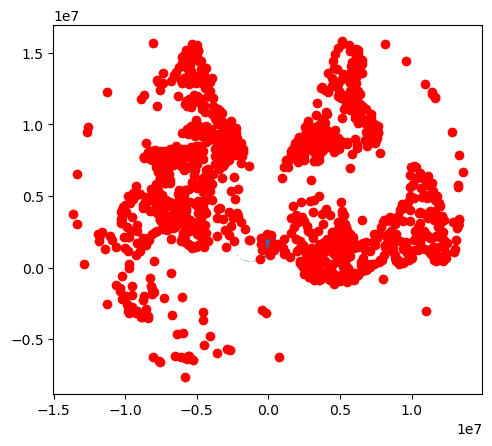

In [25]:
fig, ax = plt.subplots()

alaska.plot(ax = ax)
places.plot(ax = ax, color = 'red')

Remember than an `if-else` statement a constrol structure that allows code to make decisions: 
- it checks a condition
- if that condition is true, it executes on block of the code (the `if` block)
- if the condition is false it executes a diff bloc (the `else` block)

## Clipping

```python
updated_geodf = geopandas.clip(geodf, mask)
```

Where:
- `updated_geodf` = 'output of method' output name
- `geo_df` = 'gpd.geodf' the data to clip
- `mask` = 'gpd.geodf' the masking feature boundary (must be a geopandas gf)

<Axes: >

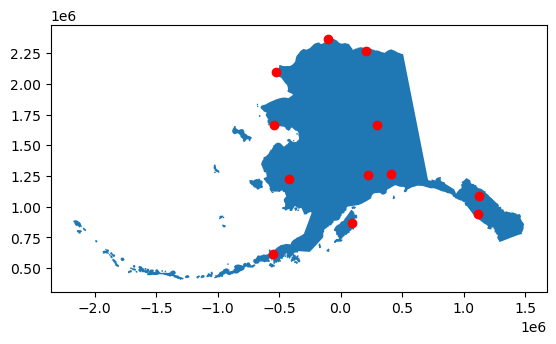

In [30]:
# Clip populated places to Alaska multipolygon

alaska_places = gpd.clip(places, alaska)

fig, ax = plt.subplots()

alaska.plot(ax = ax)
alaska_places.plot(ax = ax, color = 'red')

<Axes: >

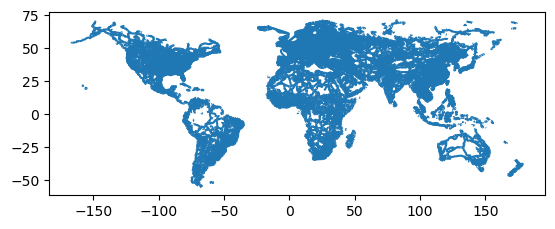

In [32]:
# Prepare roads data
roads.plot()

Before clipping or reprojecting we will subset the data to select on US roads.

**Best Practices**
Reduce tabular data before reducing via geometries.

<Axes: >

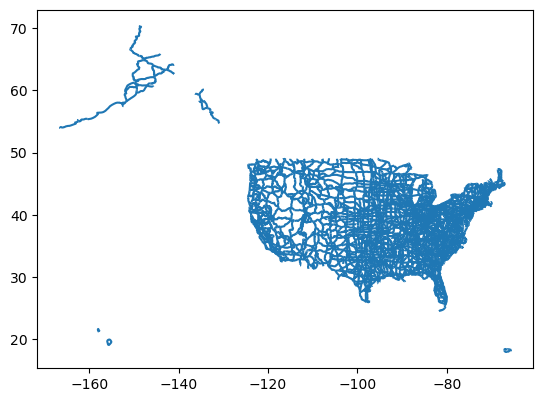

In [35]:
usa_roads = roads[roads.sov_a3 == "USA"]
usa_roads.plot()

We will now compose functions to clip `usa_roads` and `alaska` multipolygon.

In [39]:
# Reproject usa_croads and clip to alaska geom
ak_roads = gpd.clip(usa_roads.to_crs(alaska.crs), alaska)

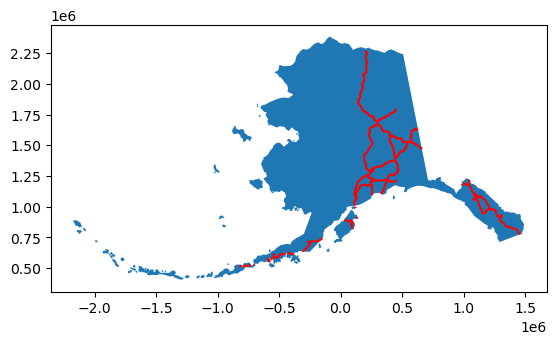

In [40]:
fig, ax = plt.subplots()
alaska.plot(ax = ax)
ak_roads.plot(ax=ax, color = 'red')
plt.show()

## Clip with a bounding box

To create a bounding box we will use the `box()` function from `shapely.geometry`. The syntax for the box is the following

```python
box(minx, miny, maxx, maxy)
```

output is a polygon representing a box

get bounds for a df

```python
bbox = box(*gdf.total_bounds)
```
`gdf` = data frame with bounding extent
`bbox` = bounding box

In [43]:
bbox = box(*alaska.total_bounds)

In [44]:
print(type(bbox))

<class 'shapely.geometry.polygon.Polygon'>


### * = unpacking operator
In the last syntax we used an asterisk & as an **unpacking operator** on the array `alaska.total_bounds`. Think about it as unpacking the elements of `alaska.total_bounds` and passing them one-by-one to the parameters `minx`, `maxx`, `maxy` of the `box()` function

In [47]:
# Create a geo-dataframe from the bounding box
ak_bbox = gpd.GeoDataFrame(geometry = [bbox], # assign geom column
                           crs = alaska.crs # assign crs
                          )

print(type(ak_bbox))
ak_bbox

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry
0,"POLYGON ((1493082.309 404545.108, 1493082.309 ..."


In [48]:
# Clip roads using Alaska bounding box

ak_complete_roads = gpd.clip(usa_roads.to_crs(ak_bbox.crs), ak_bbox)

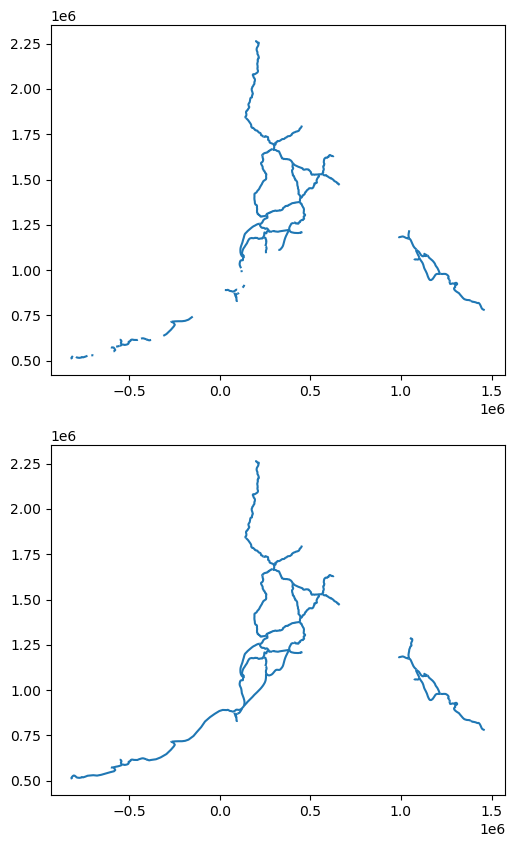

In [51]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ak_roads.plot(ax=ax1)

ak_complete_roads.plot(ax=ax2)

plt.show()

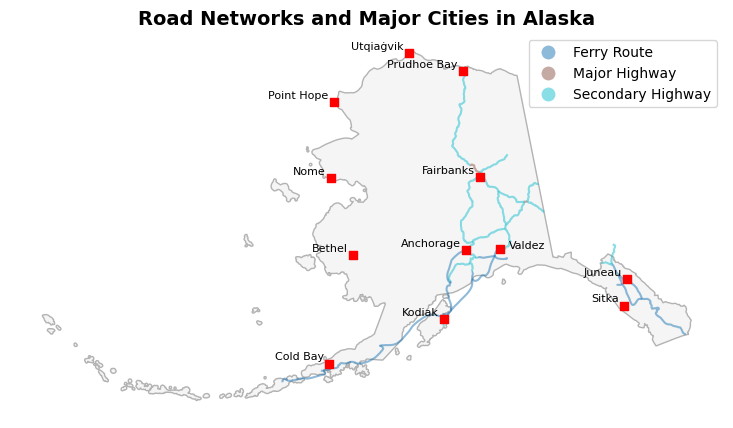

In [103]:

# Plot all layers together

fig, ax = plt.subplots(figsize = (11,5))

ax.axis('off')

alaska.plot(ax = ax, color = 'whitesmoke', edgecolor = '0.7')

# Add roads to map
ak_complete_roads.plot(ax = ax,
                       zorder = 1, # specify layer plotting order
                       column = 'type',
                       legend = True,
                       alpha = 0.5)

# Add places to map
alaska_places.plot(ax=ax,
                   zorder = 2, # on top of roads
                   color = 'red',
               marker = 's' # Square marker
              )

# Add city names as text annotations
for x, y, name in zip(alaska_places.geometry.x, alaska_places.geometry.y, alaska_places['name']):

    if name == 'Valdez': 
        ax.text(x+50000,
                y+0,
                name,
                fontsize=8,
                ha='left')

    else:
        ax.text(x-30000,
                y+20000,
                name,
                fontsize=8,
                ha='right')
        
ax.set_title("Road Networks and Major Cities in Alaska",
             fontsize=14,
             fontweight='bold')


plt.show()
